In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from multiprocessing import Pool
import time
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import norm

In [58]:
class Perceptron:
    def __init__(self,lin_separable = True, max_iter = 20, tol = 1e-4):
        self.w = []
        self.lin_separable = True
        self.max_iter = max_iter
        self.tol = tol
        
    def fit(self,X,Y):
               
        # Initialize weight vectors
        self.w.append(np.zeros((1,X.shape[1])))
        
        # For plotting classifier boundary
        z= np.linspace(-1,1,10)
        
        num_epochs = 0
        risk = [0]
        risk_dif = 10
        
        while num_epochs < self.max_iter and risk_dif > self.tol:
            
            # Shuffle data
            X,Y = shuffle(X,Y)
            
            for i,x in enumerate(X):

                if np.sign(self.w[-1] @ x.T) == Y[i]:
                    continue
                else:
                    self.w.append(self.w[-1] + Y[i]*x)
                    
            risk.append(self.score(X,Y))
            risk_dif = np.abs(risk[-1]-risk[-2])

            num_epochs = num_epochs + 1
            
        message1 = "Alg stopped by : Max epochs \n" if (num_epochs == self.max_iter) else ""
        message2 = "Alg stopped by : Risk tol \n" if risk_dif < self.tol else ""
        print("------------------------------\n",
              message1,
              message2,
              f"\n The risk is: \n {risk[-2]} , {risk[-1]}",
              f"\n The number of epochs is: \n {num_epochs}"
              "\n------------------------------")


        return(None)

    def predict(self,X):
         return np.sign(X @ self.w[-1].T)

    def score(self,X_test,Y_test):
        #Compute risk
        Y_hat = self.predict(X_test)
        return sum([Y_test[i]!=Y_hat[i] for i,aux in enumerate(Y_test)])/len(Y_test)

In [51]:
def shuffle (X,Y):
    aux = np.vstack((X.T,Y)).T
    np.random.shuffle(aux)
    X,Y = np.split(aux,[-1],axis=1)
    return(X,Y.T[0])
def gen_data_lin_sep (n,d,a):
    
    # Y = 1 with P = 0.5
    nY1 = np.random.binomial(n,0.5)
    
    # Crate first component
    X_first_compo = np.reshape(np.concatenate((np.random.uniform(-1,-a,(nY1)),
                                               np.random.uniform(a,1,(n-nY1)))),(n,1))
    # Create rest of components
    X_rest = np.reshape(np.random.uniform(-1,1,n*(d-1)),(n,(d-1))) 
    
    #Putting both together and shuffle
    X = np.hstack((X_first_compo,X_rest)) if d>1 else X_first_compo
    np.random.shuffle(X)
    
    # Create Y
    Y = [1 if x <-a else -1 for x in X[:,0]]
       
    return(X,Y)

def gen_data_non_lin_sep (n,d,m):
    
    # Y = 1 with P = 0.5
    nY1 = np.random.binomial(n,0.5)
    
    mean = np.zeros((1,d))
    mean[0,0] = m
    
    
    # Crate first normal with mean and cov matrix (0,1)
    X1 = np.random.normal(loc = -mean/2,size= ((nY1),d))
    
    # Create second normal

    X2 = np.random.normal(loc = mean/2,size= ((n-nY1),d))
    
    #Putting both together and shuffle
    X = np.vstack((X1,X2))
    
    # Create Y
    Y = [1 if x < nY1 else -1 for x,aux in enumerate(X[:,0])]
       
    return(X,Y)    

def  estimate_error_and_iters (n,d,a,lin_sep = True, rep=50):

    np.random.seed(1)
    
    # Define Perceptron classifier
    lcl_per = Perceptron()

    updates = []
    risk = []
    for r in range(rep):
        
        # Fitting model
        X,Y = gen_data_lin_sep(n,d,a) if lin_sep else gen_data_non_lin_sep(n,d,a)
        lcl_per = Perceptron(max_iter=10)
        lcl_per.fit(X,Y)
        updates.append(len(lcl_per.w)-1)

        # Testing model
        X_test,Y_test = gen_data_lin_sep(n,d,a) if lin_sep else gen_data_non_lin_sep(n,d,a)
        risk.append(lcl_per.score(X_test,Y_test))

    
    return (n,d,a,np.mean(risk),np.mean(updates))

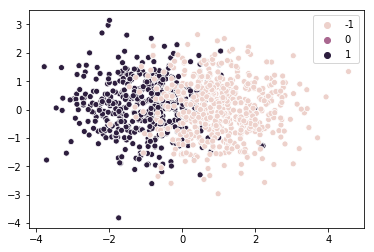

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.246] , [0.143] 
 The number of epochs is: 
 10
------------------------------


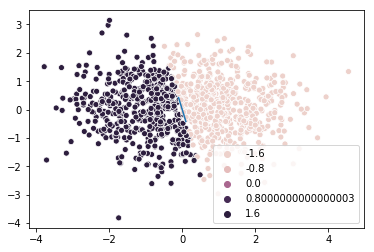

In [122]:
# Test code for class perceptron

X,Y = gen_data_non_lin_sep(1000,2,2)
sns.scatterplot(X[:,0],X[:,1],hue= Y)
plt.show()

per = Perceptron(max_iter=10)
per.fit(X,Y)

sns.scatterplot(X[:,0],X[:,1],hue= per.predict(X)[:,0])
x= np.linspace(-0.1,0.1,10)
plt.plot(x, -x*per.w[-1][0,0]/per.w[-1][0,1], linestyle='solid');

# Linearly separable

In [43]:
start_time = time.time()
import pandas as pd

ns= [10,100,1000]
ds= [2,10,100]
ais=np.linspace(0.05,0.85,15)

combinations = list(it.product(ns,ds,ais))

results = pd.DataFrame([estimate_error_and_iters(comb[0],comb[1],comb[2],True,100) for comb in combinations],
                       columns=["n","d","a","risk","updates"])

    
end_time = time.time()

print("Process time: ", round(end_time-start_time),  " seconds")

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The nu

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The numbe

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 T

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The nu

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The numbe

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 Th

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] ,

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The n

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The n

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The numb

 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
--------------

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number o

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  A

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.04] , [0.04] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is:

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The numb

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The numb

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The numb

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.04] , [0.04] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.07] , [0.07] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] ,

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01]

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01]

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01]

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 


------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 Th

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 11
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.018] , [0.018] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.014] , [0.014] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.005] , [0.005] 
 The number of epochs is: 
 11
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.004] , [0.004] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.003] , [0.003] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 12
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.012] , [0.012] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.008] , [0.008] 


------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001]

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.003] , [0.003] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 


------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The numb

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The n

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.006] , [0.006] 
 The number of epochs is: 
 13
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.017] , [0.017] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 15
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.003] , [0.003] 
 The number of epochs is: 
 21
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.011] , [0.011] 
 The number of epochs is: 
 13
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 25
------------------------------
------------------------------
  Alg stopped by : Risk

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.007] , [0.007] 
 The number of epochs is: 
 11
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.008] , [0.008] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.005] , [0.005] 
 The number of epochs is: 
 18
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.011] , [0.011] 
 The number of epochs is: 
 11
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.006] , [0.006] 
 The number of epochs is: 
 13
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 24
------------------------------
------------------------------
  Alg stopped by : Ri

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.004] , [0.004] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.004] , [0.004] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.008] , [0.008] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 14
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Ri

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 9
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 19
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.008] , [0.008] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.017] , [0.017] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.005] , [0.005] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 9
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.006] , [0.006] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.005] , [0.005] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.003] , [0.003] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 T

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.006] , [0.006] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.005] , [0.005] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.004] , [0.004] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.]

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.003] , 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.]

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.]

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.003] , [0.003] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 


------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 


------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 


------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 Th

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The numb

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 Th

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The numb

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The n

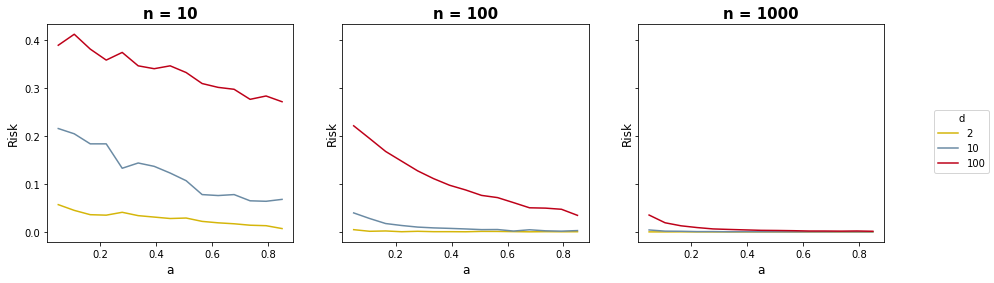

In [44]:
fig,axes= plt.subplots(nrows = 1, ncols = 3, figsize = (15,4),sharey=True)
colors = [sns.xkcd_rgb["dark yellow"],sns.xkcd_rgb["grey blue"],sns.xkcd_rgb["scarlet"]]

for k,n in enumerate(ns):
    data = results[["risk","d","a"]][results.n == n].set_index(["a","d"]).unstack()
    axes[k].set_prop_cycle('color',colors)    
    axes[k].plot(ais,data)
    axes[k].set_title(f"n = {n}",fontsize = 15,fontweight = 1000)
    axes[k].set_xlabel("a",fontsize=12)
    axes[k].set_ylabel("Risk",fontsize=12)

fig.legend(ds, loc =5,title = "d" )          
fig.savefig("Risk_separable",bbox_inches='tight')


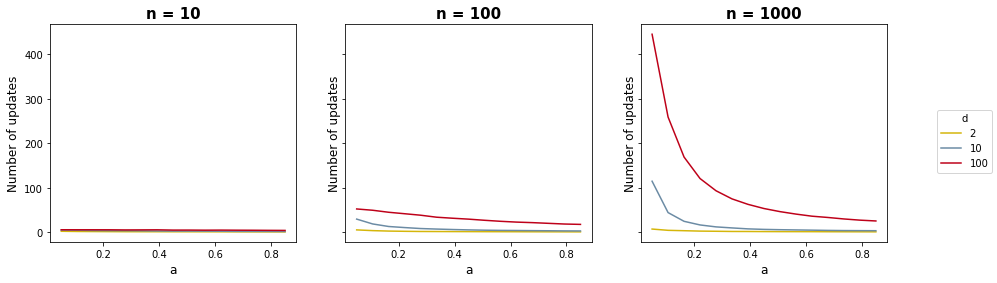

In [45]:
fig,axes= plt.subplots(nrows = 1, ncols = 3, figsize = (15,4),sharey=True)
colors = [sns.xkcd_rgb["dark yellow"],sns.xkcd_rgb["grey blue"],sns.xkcd_rgb["scarlet"]]

for k,n in enumerate(ns):
    data = results[["updates","d","a"]][results.n == n].set_index(["a","d"]).unstack()
    axes[k].set_prop_cycle('color',colors)    
    axes[k].plot(ais,data)
    axes[k].set_title(f"n = {n}",fontsize = 15,fontweight = 1000)
    axes[k].set_xlabel("a",fontsize=12)
    axes[k].set_ylabel("Number of updates",fontsize=12)
    #axes[k].set_ylim(bottom = 0)

fig.legend(ds, loc =5, title = "d")          
fig.savefig("Iterations_separable",bbox_inches='tight')

# Not linearly separable

In [64]:
start_time = time.time()
import pandas as pd

ns= [10,100,1000]
ds= [2,10,100]
ais=np.linspace(0.1,10,15)

combinations = list(it.product(ns,ds,ais))

results = pd.DataFrame([estimate_error_and_iters(comb[0],comb[1],comb[2],False,100) for comb in combinations],
                       columns=["n","d","a","risk","updates"])

    
end_time = time.time()

print("Process time: ", round(end_time-start_time),  " seconds")

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.2] , [0.2] 
 The number of epochs is: 
 9
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.6] , [0.3] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.3] , [0.3] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.4] , [0.4] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk i

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.2] , [0.2] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.2] , [0.2] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.3] , [0.3] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.3] , [0.3] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.7] , [0.7] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.5] , [0.5] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.3] , [0.3] 
 The number of epochs is: 
 9
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.4] , [0.4] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.4] , [0.4] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.3] , [0.3] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.4] , [0.4] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.2] , [0.2] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.2] , [0.2] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.2] , [0.2] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The num

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number o

------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is:

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
-------------------

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.3] , [0.3

 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.2] , [0.2] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The n

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The numb

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The numb

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The nu

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The numbe

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.53] , [0.47] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.43] , [0.43] 
 The number of epochs is: 
 9
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.43] , [0.44] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.5] , [0.53] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.47] , [0.47] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.47] , [0.47] 
 The number of epochs is: 
 9
------------------------------
------------------------------
 Alg stopped by : Max epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.51] , [0.51] 
 The number of epochs is: 
 3
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.49] , [0.5] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.62] , [0.48] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.49] , [0.47] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.47] , [0.47] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.49] , [0.49] 
 The number of epochs is: 
 3
------------------------------
------------------------------
 Alg stopped by : Max epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.49] , [0.49] 
 The number of epochs is: 
 9
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.51] , [0.31] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.45] , [0.32] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.38] , [0.38] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.47] , [0.47] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.41] , [0.41] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.27] , [0.27] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.19] , [0.19] 
 The number of epochs is: 
 7
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.21] , [0.2] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.18] , [0.18] 
 The number of epochs is: 
 7
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.29] , [0.3] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.24] , [0.26] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk to

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.22] , [0.3] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.27] , [0.27] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.22] , [0.22] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.71] , [0.37] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.28] , [0.28] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.28] , [0.28] 
 The number of epochs is: 
 2
------------------------------
------------------------------
 Alg stopped by : Max epochs

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.15] , [0.15] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.25] , [0.25] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.28] , [0.28] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.14] , [0.14] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.11] , [0.11] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.23] , [0.23] 
 The number of epochs is: 
 9
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  


------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.05] , [0.09] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.11] , [0.11] 
 The number of epochs is: 
 9
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.05] , [0.05] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.09] , [0.09] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.08] , [0.08] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.13] , [0.13] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.08] , [0.08] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.09] , [0.09] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.08] , [0.08] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.06] , [0.06] 
 The number of epochs is: 
 3
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.08] , [0.07] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.05] , [0.05] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.04] , [0.04] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 T

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.04] , [0.04] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.04] , [0.04] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 T

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The num

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.44] , [0.38] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.51] , [0.44] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.38] , [0.44] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.48] , [0.48] 
 The number of epochs is: 
 7
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.48] , [0.44] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.42] , [0.42] 
 The number of epochs is: 
 2
------------------------------
------------------------------
 Alg stopped by : Max

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.52] , [0.52] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.4] , [0.4] 
 The number of epochs is: 
 4
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.42] , [0.35] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.49] , [0.49] 
 The number of epochs is: 
 4
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.41] , [0.33] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.4] , [0.4] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 


------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.44] , [0.41] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.42] , [0.34] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.35] , [0.35] 
 The number of epochs is: 
 7
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.41] , [0.41] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.45] , [0.4] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.34] , [0.43] 
 The number of epochs is: 
 10
------------------------------
-----------------------

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.17] , [0.12] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.29] , [0.29] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.19] , [0.25] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.18] , [0.18] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.31] , [0.29] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.2] , [0.23] 
 The number of epochs is: 
 10
------------------------------
-----------------------

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.21] , [0.17] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.24] , [0.27] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.2] , [0.22] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.17] , [0.21] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.28] , [0.28] 
 The number of epochs is: 
 5
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.27] , [0.35] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : M

------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.12] , [0.12] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.11] , [0.11] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.17] , [0.17] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.11] , [0.11] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.12] , [0.12] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.2] , [0.2] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.13] , [0.07] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.11] , [0.11] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.08] , [0.08] 
 The number of epochs is: 
 9
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.05] , [0.05] 
 The number of epochs is: 
 4
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.15] , [0.14] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.01] , [0.03] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.09] , [0.09] 
 The number of epochs is: 
 5
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.07] , [0.08] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 9
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.09] , [0.09] 
 The number of epochs is: 
 2
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.08] , [0.07] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 3
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.05] , [0.05] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 4
------------------------------
------------------------------
 Al

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.]

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 8
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.08] , [0.08] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.07] , [0.05] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.08] , [0.08] 
 The number of epochs is: 
 5
------------------------------
------------------------------
 Alg stopped b

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.02] , [0.07] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.06] , [0.05] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.13] , [0.13] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.02] , [0.] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.19] , [0.11] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.14] , [0.14] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk

------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 5
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.04] , [0.04] 
 The number of epochs is: 
 10
------------------------------
----------

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.01] , [0.02] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.08] , [0.08] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.1] , [0.1] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.04] , [0.04] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.02] , [0.06] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.05] , [0.05] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 8
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg st

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.07] , [0.07] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01]

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.03] , [0.03] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] ,

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The numb

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 T

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.531] , [0.534] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.521] , [0.502] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.521] , [0.519] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.463] , [0.464] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.505] , [0.505] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.457] , [0.531] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg s

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.504] , [0.484] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.505] , [0.505] 
 The number of epochs is: 
 4
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.522] , [0.506] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.502] , [0.496] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.446] , [0.545] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.465] , [0.549] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg 

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.562] , [0.408] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.36] , [0.36] 
 The number of epochs is: 
 2
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.335] , [0.594] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.424] , [0.365] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.364] , [0.429] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.337] , [0.441] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg sto

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.34] , [0.335] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.389] , [0.384] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.322] , [0.532] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.328] , [0.395] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.484] , [0.375] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.385] , [0.385] 
 The number of epochs is: 
 8
------------------------------
------------------------------
 Alg st

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.216] , [0.219] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.21] , [0.235] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.33] , [0.213] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.244] , [0.244] 
 The number of epochs is: 
 8
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.262] , [0.227] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.249] , [0.234] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg sto

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.225] , [0.232] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.263] , [0.256] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.228] , [0.252] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.77] , [0.243] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.235] , [0.277] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.148] , [0.163] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.137] , [0.246] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.16] , [0.152] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.177] , [0.177] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.198] , [0.133] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.147] , [0.147] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.136] , [0.138] 
 The number of epochs is: 
 10
------------------------------
-----------

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.132] , [0.156] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.143] , [0.156] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.081] , [0.101] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.074] , [0.074] 
 The number of epochs is: 
 9
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.106] , [0.082] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.082] , [0.184] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg s

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.069] , [0.362] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.215] , [0.085] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.059] , [0.063] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.098] , [0.085] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.15] , [0.09] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.157] , [0.157] 
 The number of epochs is: 
 5
------------------------------
------------------------------
 Alg sto

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.038] , [0.049] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.035] , [0.041] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.047] , [0.044] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.025] , [0.025] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.04] , [0.036] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.038] , [0.037] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg st

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.063] , [0.041] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.042] , [0.042] 
 The number of epochs is: 
 9
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.04] , [0.04] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.039] , [0.039] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.042] , [0.042] 
 The number of epochs is: 
 8
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.038] , [0.032] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by :

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.01] , [0.015] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.008] , [0.008] 
 The number of epochs is: 
 3
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.027] , [0.012] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.018] , [0.022] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 9
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.012] , [0.01] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.013] , [0.013] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.014] , [0.014] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.024] , [0.024] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.021] , [0.024] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.024] , [0.024] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.019] , [0.018] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped b

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.007] , [0.006] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.012] , [0.012] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.004] , [0.004] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.015] , [0.015] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.004] , [0.004] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.007] , [0.007] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by :

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.008] , [0.004] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.005] , [0.005] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.005] , [0.005] 
 The number of epochs is: 
 3
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.005] , [0.004] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.006] , [0.006] 
 The number of epochs is: 
 3
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.012] , [0.018] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stoppe

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.006] , [0.006] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.005] , [0.005] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The ris

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.004] , [0.004] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.004] , [0.004] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 


------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The n

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.515] , [0.517] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.51] , [0.528] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.479] , [0.493] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.495] , [0.507] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.492] , [0.521] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.494] , [0.508] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.495] , [0.513] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.51] , [0.527] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.467] , [0.491] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.476] , [0.476] 
 The number of epochs is: 
 9
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.473] , [0.478] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.478] , [0.505] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg st

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.447] , [0.382] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.445] , [0.463] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.431] , [0.407] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.387] , [0.445] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.46] , [0.389] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.41] , [0.431] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg 

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.371] , [0.448] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.409] , [0.426] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.387] , [0.404] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.427] , [0.434] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.343] , [0.441] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.37] , [0.518] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.322] , [0.335] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.322] , [0.308] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.29] , [0.298] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.27] , [0.294] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.34] , [0.306] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.25] , [0.338] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg st

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.315] , [0.389] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.272] , [0.357] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.323] , [0.33] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.323] , [0.276] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.267] , [0.446] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.293] , [0.282] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.23] , [0.184] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.19] , [0.145] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.216] , [0.158] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.172] , [0.179] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.177] , [0.238] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.27] , [0.153] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg s

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.146] , [0.19] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.157] , [0.152] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.18] , [0.194] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.158] , [0.141] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.191] , [0.18] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.207] , [0.197] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg s

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.13] , [0.153] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.115] , [0.089] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.097] , [0.112] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.121] , [0.128] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.103] , [0.083] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.084] , [0.098] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.083] , [0.117] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.082] , [0.087] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.079] , [0.101] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.116] , [0.109] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.07] , [0.093] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.11] , [0.089] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg 

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.06] , [0.071] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.043] , [0.043] 
 The number of epochs is: 
 8
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.041] , [0.032] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.048] , [0.049] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.036] , [0.044] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.039] , [0.057] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg st

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.056] , [0.057] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.033] , [0.055] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.037] , [0.05] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.046] , [0.06] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.027] , [0.027] 
 The number of epochs is: 
 7
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.049] , [0.055] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg sto

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.022] , [0.022] 
 The number of epochs is: 
 9
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.018] , [0.018] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.02] , [0.02] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.012] , [0.012] 
 The number of epochs is: 
 8
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.023] , [0.029] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.015] , [0.03] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.023] , [0.023] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.022] , [0.022] 
 The number of epochs is: 
 3
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.008] , [0.006] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.012] , [0.024] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.01] , [0.01] 
 The number of epochs is: 
 10
------------------------------
--------------------

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.007] , [0.007] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.006] , [0.006] 
 The number of epochs is: 
 5
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.01] , [0.012] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.005] , [0.006] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.006] , [0.007] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Ris

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.006] , [0.006] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 9
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.003] , [0.003] 
 The number of epochs is: 
 5
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.004] , [0.006] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 9
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.006] , [0.005] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Ri

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.003] , [0.003] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.003] , [0.003] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 T

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.453] , [0.427] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.43] , [0.432] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.453] , [0.451] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.419] , [0.443] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.419] , [0.436] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by 

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.42] , [0.461] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.458] , [0.458] 
 The number of epochs is: 
 8
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.446] , [0.417] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.47] , [0.462] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.453] , [0.453] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.453] , [0.454] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stoppe

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.369] , [0.347] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.38] , [0.383] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.382] , [0.397] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.367] , [0.393] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.375] , [0.388] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.385] , [0.361] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.367] , [0.396] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.347] , [0.355] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.38] , [0.346] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.383] , [0.383] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.365] , [0.357] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.343] , [0.342] 
 The number of epochs is: 
 10
------------------------------
--------

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.241] , [0.249] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.278] , [0.29] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.244] , [0.244] 
 The number of epochs is: 
 5
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.239] , [0.238] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.268] , [0.24] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.295] , [0.295] 
 The number of epochs is: 
 10
------------------------------
------------

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.255] , [0.24] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.262] , [0.294] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.249] , [0.234] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.244] , [0.249] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.219] , [0.236] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.257] , [0.267] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Al

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.137] , [0.146] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.15] , [0.15] 
 The number of epochs is: 
 5
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.145] , [0.14] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.131] , [0.122] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.12] , [0.138] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.132] , [0.132] 
 The number of epochs is: 
 10
------------------------------
--------------

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.184] , [0.173] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.146] , [0.168] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.165] , [0.165] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.163] , [0.163] 
 The number of epochs is: 
 4
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.14] , [0.133] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.136] , [0.134] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopp

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.085] , [0.075] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.085] , [0.085] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.078] , [0.078] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.085] , [0.085] 
 The number of epochs is: 
 2
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.056] , [0.062] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.052] , [0.052] 
 The number of epochs is: 
 9
------------------------------
------------------------------
  Alg stopped b

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.076] , [0.076] 
 The number of epochs is: 
 6
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.082] , [0.074] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.077] , [0.076] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.067] , [0.078] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.081] , [0.073] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.088] , [0.088] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg sto

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.024] , [0.024] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.038] , [0.038] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.036] , [0.036] 
 The number of epochs is: 
 5
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.028] , [0.023] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.022] , [0.018] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.027] , [0.019] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.028] , [0.031] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.035] , [0.032] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.032] , [0.021] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.025] , [0.016] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.028] , [0.028] 
 The number of epochs is: 
 7
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.02] , [0.027] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg st

------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.005] , [0.004] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.005] , [0.005] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.018] , [0.018] 
 The number of epochs is: 
 2
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.004] , [0.003] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
 Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 8
------------------------------
----------------------

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.003] , [0.003] 
 The number of epochs is: 
 9
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.007] , [0.007] 
 The number of epochs is: 
 7
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.008] , [0.01] 
 The number of epochs is: 
 10
------------------------------
------------------------------
 Alg stopped by : Max epochs 
  
 The risk is: 
 [0.001] , [0.] 
 The number of epochs is: 
 10
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.023] , [0.023] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk t

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.005] , [0.005] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.005] , [0.005] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 7
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 8
------------------------------
------------------------------
  Alg stopped by : Ri

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 5
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 6
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.002] , [0.002] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.]

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 T

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The numb

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.001] , [0.001] 
 The number of epochs is: 
 2
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number 

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 4
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The numb

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epo

------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of epochs is: 
 1
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 [0.] , [0.] 
 The number of epochs is: 
 3
------------------------------
------------------------------
  Alg stopped by : Risk tol 
 
 The risk is: 
 0 , [0.] 
 The number of 

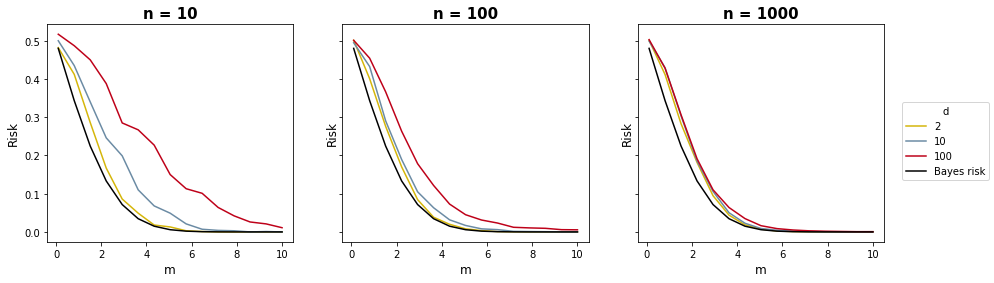

In [65]:
fig,axes= plt.subplots(nrows = 1, ncols = 3, figsize = (15,4),sharey=True)
colors = [sns.xkcd_rgb["dark yellow"],sns.xkcd_rgb["grey blue"],sns.xkcd_rgb["scarlet"]]

for k,n in enumerate(ns):
    data = results[["risk","d","a"]][results.n == n].set_index(["a","d"]).unstack()
    axes[k].set_prop_cycle('color',colors)    
    axes[k].plot(ais,data)
    axes[k].set_title(f"n = {n}",fontsize = 15,fontweight = 1000)
    axes[k].set_xlabel("m",fontsize=12)
    axes[k].set_ylabel("Risk",fontsize=12)
    
    # Bayes risk plot
    
    bay_risk = [norm.cdf(x=0, loc =loc/2) for loc in ais]
    axes[k].plot(ais,bay_risk,color = 'black')

fig.legend(["2","10","100","Bayes risk"], loc =5,title = "d" )          
fig.savefig("Risk__non_separable",bbox_inches='tight')

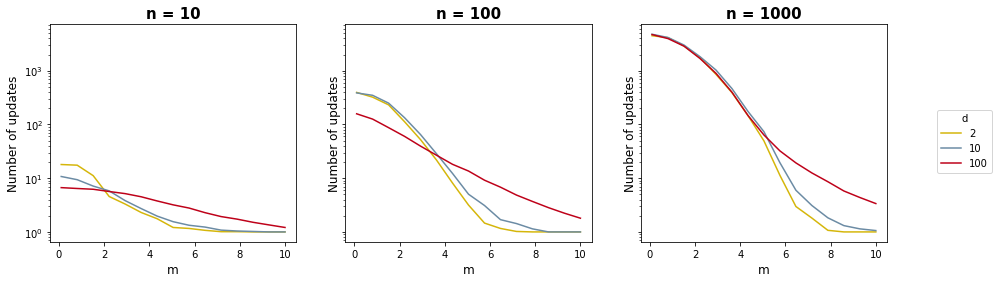

In [77]:
fig,axes= plt.subplots(nrows = 1, ncols = 3, figsize = (15,4),sharey=True)
colors = [sns.xkcd_rgb["dark yellow"],sns.xkcd_rgb["grey blue"],sns.xkcd_rgb["scarlet"]]

ns= [10,100,1000]
for k,n in enumerate(ns):
    data = results[["updates","d","a"]][results.n == n].set_index(["a","d"]).unstack()
    axes[k].set_prop_cycle('color',colors)    
    axes[k].plot(ais,data)
    axes[k].set_title(f"n = {n}",fontsize = 15,fontweight = 1000)
    axes[k].set_xlabel("m",fontsize=12)
    axes[k].set_ylabel("Number of updates",fontsize=12)
    axes[k].set_yscale("log")


fig.legend(ds, loc =5, title = "d")          
fig.savefig("Iterations_non_separable",bbox_inches='tight')